In [1]:
using Gen, Plots


In [12]:
bearing(x, y) = atan(y, x)

@gen function model(T::Int)

    measurement_noise = 0.005
    velocity_var = 1e-6

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # prior on initial x-coordinate
    x = {:x0} ~ normal(0.01, 0.01)

    # prior on initial y-coordinate
    y = {:y0} ~ normal(0.95, 0.01)

    # prior on x-component of initial velocity
    vx = {:vx0} ~ normal(0.002, 0.01)

    # prior on y-component of initial velocity
    vy = {:vy0} ~ normal(-0.013, 0.01)

    # initial bearing measurement
    z0 ~ normal(bearing(x, y), measurement_noise)

    # record position
    xs[1] = x
    ys[1] = y

    # generate successive states and measurements
    for t=1:T
        a = {(:a, t)} ~ normal(0, 1)
        speedup_x = a*vx
        speedup_y = a*vy

        # update the state of the point
        vx = {(:vx, t)} ~ normal(speedup_x, sqrt(velocity_var))
        vy = {(:vy, t)} ~ normal(speedup_y, sqrt(velocity_var))
        x += vx
        y += vy

        # bearing measurement
        {(:z, t)} ~ normal(bearing(x, y), measurement_noise)

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end

    # return the sequence of positions
    return (xs, ys)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], var"##model#316", Bool[0], false)

In [13]:
import Random
Random.seed!(3)

# generate trace with specific initial conditions
T = 50
constraints = Gen.choicemap((:x0, 0.01), (:y0, 0.95), (:vx0, 0.002), (:vy0, -0.013))
(trace, _) = Gen.generate(model, (T,), constraints)

# extract the observed data (zs) from the trace
choices = Gen.get_choices(trace)
zs = Vector{Float64}(undef, T+1)
zs[1] = choices[:z0]
for t=1:T
    zs[t+1] = choices[(:z, t)]
end

In [4]:
function render(trace; show_data=true, max_T=get_args(trace)[1], overlay=false)
    (T,) = Gen.get_args(trace)
    (xs, ys) = Gen.get_retval(trace)
    
    zs = Vector{Float64}(undef, T+1)
    zs[1] = trace[:z0]
    for t=1:T
        zs[t+1] = trace[(:z, t)]
    end
    
    f = overlay ? scatter! : scatter
    fig = f(xs[1:max_T+1], ys[1:max_T+1], s=:auto, label=nothing)
    
    if show_data
        for z in zs[1:max_T+1]
            dx = cos(z) * 0.5
            dy = sin(z) * 0.5
            plot!([0., dx], [0., dy], color="red", alpha=0.3, label=nothing)
        end
    end
    
    return fig
end;

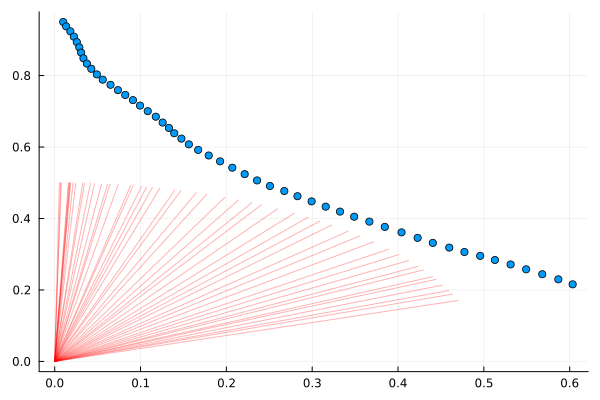

In [5]:
plot(label=nothing)
render(trace)

In [16]:
function particle_filter(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    
    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    
    # steps
    for t=1:length(zs)-1
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        print(obs)
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [17]:
print(zs)
@time pf_traces = particle_filter(5000, zs, 200);


[1.5569515820053956, 1.5640497074633712, 1.557432189599302, 1.5502553164600439, 1.5538638345970817, 1.5527636580617494, 1.5507912761353748, 1.5592224738498341, 1.5614859564239916, 1.5557333954151802, 1.5558270988797391, 1.553023058920822, 1.5680186304735624, 1.5625574636657633, 1.5573045608587393, 1.5605145342606803, 1.5721009822703065, 1.5547837713464623, 1.548953646244932, 1.558888741848037, 1.5503182396515673, 1.5513014092806479, 1.5617781468531617, 1.5656921207619792, 1.5643115026845327, 1.5638514594985167, 1.5682874079816986, 1.5732334743095933, 1.5646542350755022, 1.5604645301554225, 1.5572831691289384, 1.5691710244489514, 1.5647516444551346, 1.5617108843258956, 1.5673980844297684, 1.5545409372262677, 1.561277082291872, 1.5494998652165386, 1.55365262723783, 1.5577804011488081, 1.5582182328548406, 1.5578015130290113, 1.5557865219880354, 1.5624263865110923, 1.5616241649103682, 1.549715919356064, 1.5580281174196806, 1.5674167775701384, 1.5623379311870984, 1.5701216672370986, 1.56188

In [9]:
function overlay(renderer, traces; same_data=true, args...)
    fig = plot(title="Observed bearings (red) and \npositions of individual traces (one color per trace)",
            xlabel="X", ylabel="Y")
    
    renderer(traces[1], show_data=true, overlay=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, overlay=true, args...)
    end
    fig
end;

In [10]:
function particle_filter_no_resampling(num_particles::Int, zs::Vector{Float64}, num_samples::Int)

    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)

    # steps
    for t=1:length(zs)-1
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

 22.841258 seconds (506.39 M allocations: 16.135 GiB, 37.00% gc time)


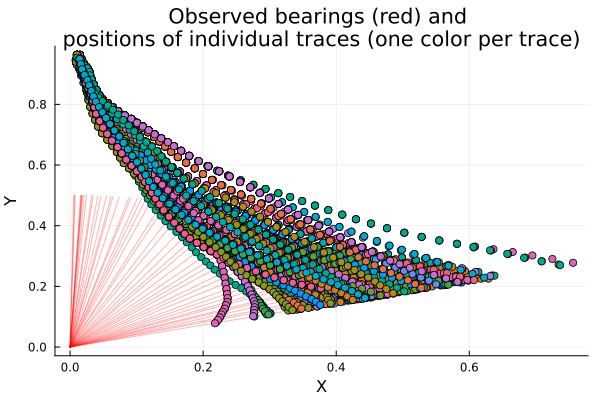

In [11]:
@time pf_traces_no_resampling = particle_filter_no_resampling(5000, zs, 200);
overlay(render, pf_traces_no_resampling)

In [2]:
struct State
    X::Float64
    Y::Float64
    vx::Float64
    vy::Float64
end
bearing(x, y) = atan(y, x)

@gen (static) function kernel(t::Int, prev_state::State,
                              velocity_var::Float64, measurement_noise::Float64, m::Float64, k::Float64)
    vx ~ normal(prev_state.vx, sqrt(velocity_var))
    vy ~ normal(prev_state.vy, sqrt(velocity_var))
    x = prev_state.X + vx
    y = prev_state.Y + vy
    z ~ normal(bearing(x, y), measurement_noise)
    next_state = State(x, y, vx, vy)
    return next_state
end

chain = Gen.Unfold(kernel)

Gen.@load_generated_functions # To allow use of the generative function written in the static modeling language above.

In [3]:
trace = Gen.simulate(chain, (4, State(0., 0., 0., 0.), 0.01, 0.01, 0.0, 0.0))
Gen.get_choices(trace)

│
├── 1
│   │
│   ├── :vx : -0.07591026936408697
│   │
│   ├── :vy : -0.20636344400295403
│   │
│   └── :z : -1.9165680784749768
│
├── 2
│   │
│   ├── :vx : -0.011817866297308244
│   │
│   ├── :vy : -0.23587318993674722
│   │
│   └── :z : -1.7556232258875273
│
├── 3
│   │
│   ├── :vx : -0.025616630520071723
│   │
│   ├── :vy : -0.26254384145971543
│   │
│   └── :z : -1.7305195940904479
│
└── 4
    │
    ├── :vx : 0.06676425803193323
    │
    ├── :vy : -0.21989640825039244
    │
    └── :z : -1.625437894256851


In [25]:
using Gen, Plots


struct State
    beta_t::Float64
    S_t::Int
    I_t::Int
end
@dist lognormal(x, y) = exp(normal(x, y))

@gen (static) function kernel(t::Int, prev_state::State, Population::Int, tau::Int, R0::Float64, 
        switch_to_rho1::Int, switch_to_rho2::Int, rho0::Float64, rho1::Float64, rho2::Float64)

    beta_t ~ lognormal(log(prev_state.beta_t), 0.1)
    R_t = R0 * beta_t
    
    individual_rate = R_t / tau
    combined_p = 1 - (1-individual_rate/Population)^prev_state.I_t
    S2I ~ binom(prev_state.S_t, combined_p) # susceptible to infected
    I2R ~ binom(prev_state.I_t, 1/tau) # infected to recovered
    S_t = prev_state.S_t - S2I
    I_t = prev_state.I_t + S2I - I2R
    rho_to_use = t >= switch_to_rho2 ? rho2 : (t > switch_to_rho1 ? rho1 : rho0)
    obs ~ binom(S2I, rho_to_use)
    return State(beta_t, S_t, I_t)
end


@gen function unfold_model(T::Int)
    Population = 600 # population size
    S_0 = 599 # susceptible part of population
    I_0 = 1 # number of infected people at time step 1
    beta_0 = 1.0
    
    tau ~ uniform_discrete(2, 9)
    R0 ~ lognormal(0.0, 1.0)
    rho0 ~ beta(2, 4)
    rho1 ~ beta(4, 4)
    rho2 ~ beta(8, 4)
    switch_to_rho1 ~ uniform_discrete(15, 40)
    switch_to_rho2 ~ uniform_discrete(30, 60)
    
    init_state = State(beta_0, S_0, I_0)
    chain = Gen.Unfold(kernel)
    
    chain ~ chain(T, init_state, Population, tau, R0, switch_to_rho1, switch_to_rho2, rho0, rho1, rho2)
    result = (init_state, chain)
    return result
end
Gen.@load_generated_functions


In [26]:
function unfold_particle_filter(num_particles::Int, os::Vector{Int}, num_samples::Int)
    init_obs = Gen.choicemap((:chain => 1 => :obs, os[1]))
    state = Gen.initialize_particle_filter(unfold_model, (1,), init_obs, num_particles)
    
    for t=2:length(os)-1
        maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap((:chain => t => :obs, os[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end

    # return a sample of traces from the weighted collection:
    return Gen.sample_unweighted_traces(state, num_samples)
end;



In [27]:
import Random
Random.seed!(3)

T = 59
(trace, _) = Gen.generate(unfold_model, (T,))

choices = Gen.get_choices(trace)
println("tau: $(choices[:tau]), R0: $(choices[:R0]), rho0: $(choices[:rho0]), rho1: $(choices[:rho1]), rho2: $(choices[:rho2]), switch_to_rho1: $(choices[:switch_to_rho1]), switch_to_rho2: $(choices[:switch_to_rho2])")

o = Vector{Int}(undef, T)
for t=1:T
    o[t] = choices[:chain => t => :obs]
end
print(o)



tau: 4, R0: 3.9087141576446593, rho0: 0.2712996450469065, rho1: 0.7159532341778375, rho2: 0.7255963142899545, switch_to_rho1: 27, switch_to_rho2: 38
[1, 0, 3, 2, 2, 3, 5, 3, 3, 6, 10, 8, 8, 10, 12, 7, 11, 2, 9, 7, 5, 2, 0, 1, 1, 5, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:


@time unfold_pf_traces = unfold_particle_filter(5000, o, 200);
cho_res = Gen.get_choices(unfold_pf_traces[1])
println("tau: $(cho_res[:tau]), R0: $(cho_res[:R0]), rho0: $(cho_res[:rho0]), rho1: $(cho_res[:rho1]), rho2: $(cho_res[:rho2]), switch_to_rho1: $(cho_res[:switch_to_rho1]), switch_to_rho2: $(cho_res[:switch_to_rho2])")


LoadError: DomainError with [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]:
Categorical: vector p is not a probability vector